# Customers Analysis

<a target="_blank" href="https://colab.research.google.com/github/vitostamatti/intro-python/blob/main/notebooks/05-clustering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


**RFM Modeling**

- **frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

- **T** represents the age of the customer in whatever time units chosen. This is equal to the duration between a customer’s first purchase and the end of the period under study.

- **recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

- **monetary_value** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.


In [1]:
import pandas as pd
import numpy as np

In [35]:
path = "https://raw.githubusercontent.com/vitostamatti/intro-python/main/data/online-retail/online-retail.csv"
df = pd.read_csv(
    path,
    sep=";",
    decimal=",",
    parse_dates=["InvoiceDate"],
    date_format="%d/%m/%Y %H:%M",
)
# pd.to_datetime(df['InvoiceDate'])

In [38]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [39]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [40]:
# basic cleaning
# Let's get the duplicated rows
df = df.drop_duplicates()
df = df.dropna(subset=["CustomerID"])
df = df.loc[df["Quantity"] > 0]
df = df.loc[df["UnitPrice"] > 0]
q99up = df["UnitPrice"].quantile(0.99)
q99qt = df["Quantity"].quantile(0.99)

# extreme customers
df_out = df[(df["UnitPrice"] > q99up * 3) | (df["Quantity"] > q99qt * 3)]
df_in = df[(df["UnitPrice"] <= q99up * 3) & (df["Quantity"] <= q99qt * 3)]

In [41]:
df_in.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,391563.000000,391563,391563.000000,391563.000000
mean,11.439015,2011-07-10 20:13:38.567433472,2.870472,15287.362700
min,1.000000,2010-12-01 08:26:00,0.001000,12347.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13955.000000
50%,6.000000,2011-07-31 12:16:00,1.950000,15150.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,360.000000,2011-12-09 12:50:00,42.950000,18287.000000
std,22.687948,NaN,3.075983,1713.224438


In [42]:
df_out.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,1129.000000,1129,1129.000000,1129.000000
mean,596.020372,2011-06-26 05:25:44.906996992,91.718857,15454.722764
min,1.000000,2010-12-01 09:58:00,0.040000,12346.000000
25%,1.000000,2011-03-24 18:34:00,0.420000,13983.000000
50%,432.000000,2011-07-08 11:52:00,1.650000,15581.000000
75%,600.000000,2011-09-30 13:28:00,50.000000,17306.000000
max,80995.000000,2011-12-09 09:15:00,8142.750000,18251.000000
std,3289.610100,NaN,401.319158,1812.650479


```sql
SELECT
  customer_id,
  COUNT(distinct date(transaction_at)) - 1 as frequency,
  datediff('day', MIN(transaction_at), MAX(transaction_at)) as recency,
  AVG(total_price) as monetary_value,
  datediff('day', CURRENT_DATE, MIN(transaction_at)) as T
FROM orders
GROUP BY customer_id
```


In [43]:
from datetime import datetime

reference_date = df_in["InvoiceDate"].max().date()


def compute_frequency(x):
    return np.unique(x).shape[0] - 1


def compute_recency(x: pd.Series):
    min_date = x.min()
    max_date = x.max()
    return (max_date - min_date).days


def compute_T(x):
    min_date = x.min().date()
    return (reference_date - min_date).days


data = (
    df_in.assign(
        PurchaseDate=lambda d: pd.to_datetime(d["InvoiceDate"].dt.date),
        TotalPurchase=lambda d: d["Quantity"] * d["UnitPrice"],
    )
    .groupby(["CustomerID", "PurchaseDate"])
    .agg({"TotalPurchase": "sum"})
    .reset_index()
    .groupby("CustomerID")
    .agg(
        frequency=("PurchaseDate", compute_frequency),
        recency=("PurchaseDate", compute_recency),
        T=("PurchaseDate", compute_T),
        monetary_value=("TotalPurchase", "mean"),
    )
)

## Clustering


In [44]:
X = data.copy()

In [45]:
for col in X.columns:
    if X[col].skew() > 5:
        X[col] = np.log(X[col] + 1)

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PowerTransformer,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
import numpy as np

sils = []
ks = []
for k in range(3, 11):
    m = make_pipeline(MinMaxScaler(), KMeans(n_clusters=k, n_init="auto"))
    m.fit(X)
    silhouette_avg = silhouette_score(X, m[-1].labels_)
    sils.append(silhouette_avg)
    ks.append(k)
    print("Silhouette coefficient for %i clusters: %0.3f" % (k, silhouette_avg))
best_k = ks[np.argmax(sils)]

Silhouette coefficient for 3 clusters: 0.540
Silhouette coefficient for 4 clusters: 0.550
Silhouette coefficient for 5 clusters: 0.523
Silhouette coefficient for 6 clusters: 0.421
Silhouette coefficient for 7 clusters: 0.429
Silhouette coefficient for 8 clusters: 0.378
Silhouette coefficient for 9 clusters: 0.388
Silhouette coefficient for 10 clusters: 0.398


In [47]:
m = make_pipeline(MinMaxScaler(), KMeans(n_clusters=best_k, n_init="auto"))
X["Cluster"] = m.fit_predict(X)

In [53]:
X.columns

Index(['frequency', 'recency', 'T', 'monetary_value', 'Cluster'], dtype='object')

<Axes: xlabel='Cluster', ylabel='count'>

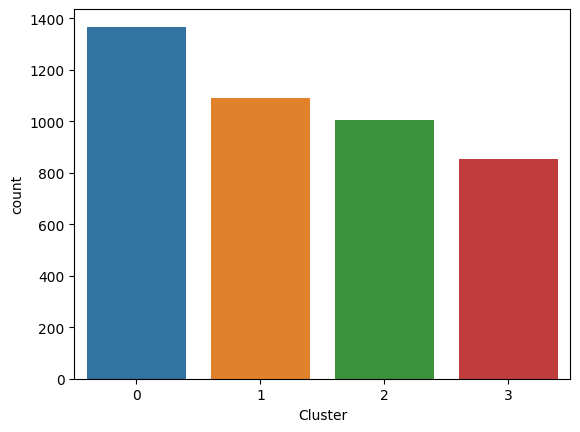

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(X, x="Cluster")

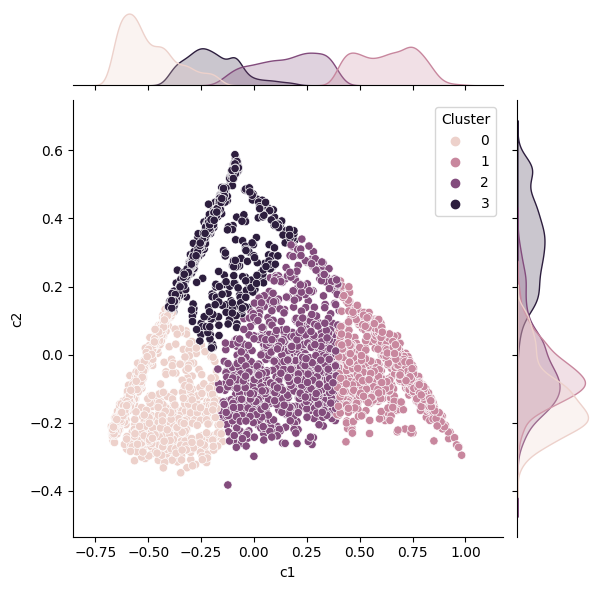

In [49]:
from sklearn.decomposition import PCA

pca = make_pipeline(MinMaxScaler(), PCA(n_components=2))
data_pca = pca.fit_transform(X.drop(columns="Cluster"))
data_pca = pd.DataFrame(data_pca, columns=["c1", "c2"])
data_pca["Cluster"] = X["Cluster"].values
sns.jointplot(data_pca, x="c1", y="c2", hue="Cluster")

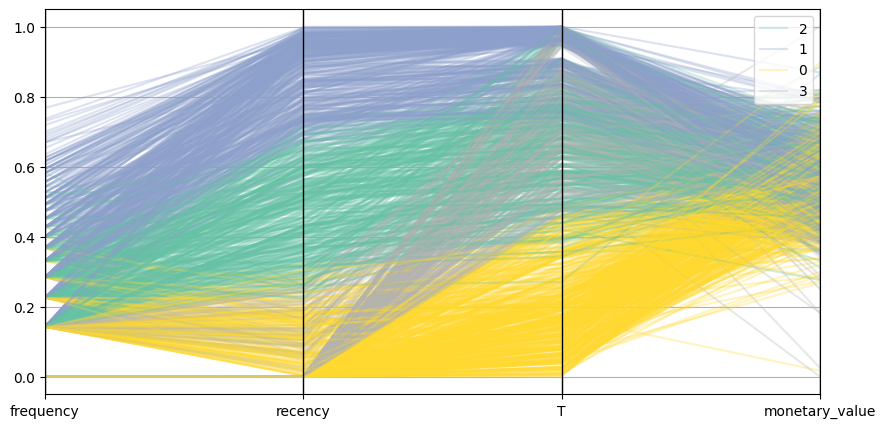

In [50]:
from pandas.plotting import parallel_coordinates

X_scaled = MinMaxScaler().fit_transform(X.drop(columns=["Cluster"]))
X_scaled = pd.DataFrame(
    X_scaled, columns=X.drop(columns=["Cluster"]).columns, index=X.index
)
X_scaled["Cluster"] = X["Cluster"]

plt.figure(figsize=(10, 5))
parallel_coordinates(
    X_scaled.sample(1500), "Cluster", colormap=plt.get_cmap("Set2"), alpha=0.3
)
plt.show()

In [51]:
# saving a model
import pickle

with open("../data/models/rfm-kmeans.pkl", "wb") as f:
    pickle.dump(m, f)

## Customers Lifetime Value (Optional)

- https://web-docs.stern.nyu.edu/old_web/emplibrary/Peter%20Fader.pdf


In [ ]:
!pip install lifetimes

In [69]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data["frequency"], data["recency"], data["T"])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4315 subjects, a: 0.00, alpha: 69.13, b: 6.91, r: 0.83>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

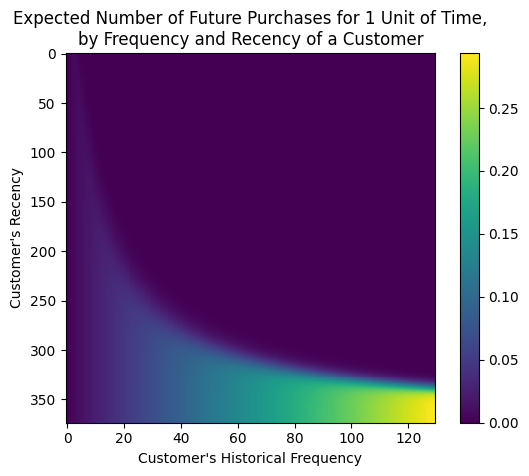

In [70]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 120 times from you, and their latest purchase was when they were 365 days old, then they are your best customer (bottom-right). Your coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

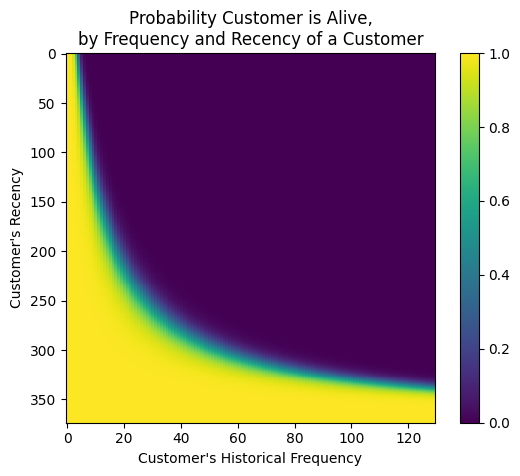

In [71]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [72]:
t = 1
data["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, data["frequency"], data["recency"], data["T"]
)
data.sort_values(by="predicted_purchases", ascending=False).head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14911.0,129,372,373,1040.464077,0.293628
12748.0,112,373,373,276.499912,0.255181
17841.0,111,372,373,361.784286,0.252917
15311.0,89,373,373,673.697222,0.203160
14606.0,88,372,373,134.732022,0.200896


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

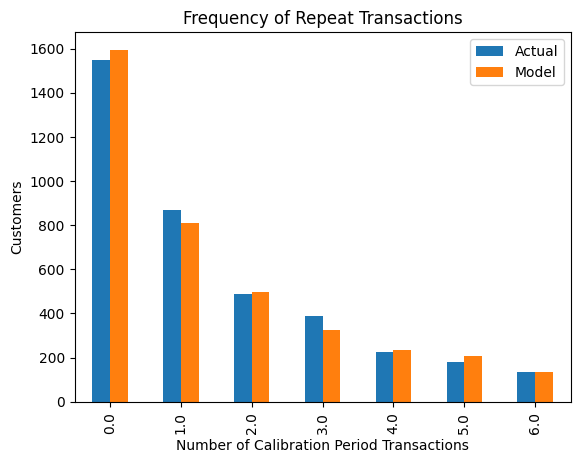

In [54]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

In [87]:
data_clv = data[data["frequency"] > 0]
data_clv[["monetary_value", "frequency"]].corr()

,monetary_value,frequency
monetary_value,1.000000,0.159123
frequency,0.159123,1.000000


- http://www.brucehardie.com/notes/025/gamma_gamma.pdf


In [89]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(data_clv["frequency"], data_clv["monetary_value"])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2768 subjects, p: 3.46, q: 3.59, v: 304.21>


In [155]:
print(
    ggf.conditional_expected_average_profit(
        data_clv["frequency"], data_clv["monetary_value"]
    )
)

CustomerID
12347.0    592.476066
12348.0    440.712880
12352.0    256.636555
12356.0    792.530004
12358.0    507.917125
              ...    
18272.0    499.182206
18273.0    160.146306
18282.0    224.860563
18283.0    160.278052
18287.0    556.268022
Length: 2768, dtype: float64


<Axes: >

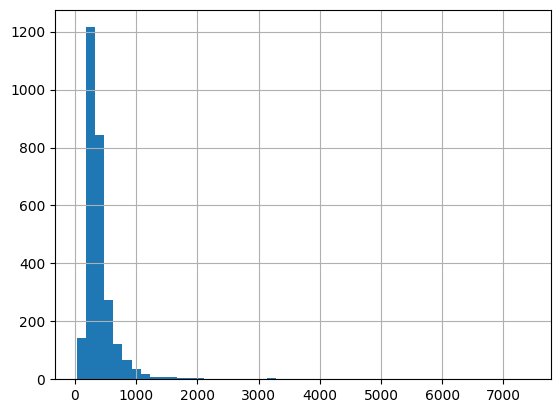

In [156]:
ggf.conditional_expected_average_profit(
    data_clv["frequency"], data_clv["monetary_value"]
).hist(bins=50)

<Axes: >

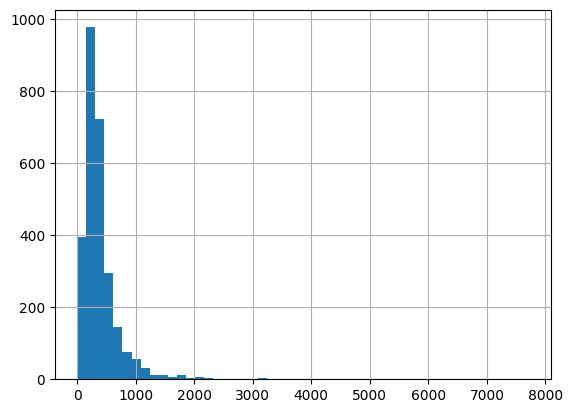

In [157]:
data_clv["monetary_value"].hist(bins=50)

In [98]:
print(
    "Expected conditional average profit: %s, Average profit: %s"
    % (
        ggf.conditional_expected_average_profit(
            data["frequency"], data["monetary_value"]
        ).mean(),
        data[data["frequency"] > 0]["monetary_value"].mean(),
    )
)

Expected conditional average profit: 409.4903564824079, Average profit: 403.5867023516091


In [99]:
bgf.fit(data["frequency"], data["recency"], data["T"])

print(
    ggf.customer_lifetime_value(
        bgf,  # the model to use to predict the number of future transactions
        data["frequency"],
        data["recency"],
        data["T"],
        data["monetary_value"],
        time=12,  # months
        discount_rate=0.01,  # monthly discount rate ~ 12.7% annually
    ).head(10)
)

CustomerID
12347.0    3127.944711
12348.0    1331.121062
12349.0    1299.026326
12350.0     298.811924
12352.0    1617.701362
12353.0     414.725439
12354.0     376.178782
12355.0     400.083901
12356.0    1916.778375
12357.0    1108.401559
Name: clv, dtype: float64
